# Project Overview

Beta Bank customers are leaving the bank little by little, chipping away every month. The bankers have figured out that it’s cheaper to save the existing customers rather than to attract new ones.

We need to predict whether a customer will leave the bank soon. We have the data on clients’ past behavior and termination of contracts with the bank.

### Project Goal

Build a model with the maximum possible F1 score. The model's F1 score for the test set must be at least 0.59. 

Additionally, we will compare the AUC-ROC metric to the F1 score and interpret the comparison.

### Data Description
Here\'s an overview of the fields in the dataset:
- Features
    - RowNumber — the data string index
    - CustomerId — the unique customer identifier
    - Surname — the surname of the customer
    - CreditScore — the credit score of the customer
    - Geography — the customer's country of residence
    - Gender — the customer's gender
    - Age — the customer's age
    - Tenure — the period of maturation for a customer’s fixed deposit (years)
    - Balance — the customer's account balance
    - NumOfProducts — the number of banking products used by the customer
    - HasCrCard — whether or not the customer has a credit card
    - IsActiveMember — whether or not the customer is active
    - EstimatedSalary — the customer's estimated salary
- Target
    - Exited — whether or not the сustomer has left the bank

### Project Plan

1. Import the necessary libraries for the project.
2. Load and inspect the data set.
3. Drop unnecessary columns and fill missing values in.
4. Preprocess the data by encoding categorical variables.
5. Define the features and target for the model.
6. Study the class balance of the target.
7. Split the source data into training, validation, and testing sets.
8. Optimize the model's hyperparameters.
9. Train and fit the model. Calculate its f1 score.
10. Address the class imbalance, re-train and fit the model, and calculate the new f1 score.
11. Calculate the score for the testing set.
12. Calculate the AUC ROC score.

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, mean_squared_error, precision_recall_curve, roc_curve, roc_auc_score

### Load and Inspect the Data Set

In [2]:
# load the csv file to a dataframe named churn
churn = pd.read_csv('/datasets/Churn.csv')

# preview the first 5 rows of the dataframe
print(churn.head())

# get info about churn
print('\n',churn.info())

# describe churn
print('\n',churn.describe())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

The RowNumber column doesn't serve any practical purpose so I will drop it from the dataframe. 

The CustomerId column also should be removed because it is just an identifier and will not inform the model in any meaningful way.

Lastly, Surname should also be removed because it is also an identifier (although not unique) that will not inform the mdoel in any meaningful way; instead, it would add noise to the model and introduce high cardinality if attempted to be converted to numeric values for the model to use.

Tenure is the only column with obvious missing values. I can logically fill those in based on the medin value of the Age column. (The mean and median for the Tenure column are just about equal so it doesn't really matter if we use the mean or median value to fill missing values in.)

In [3]:
# check for duplicates in churn
print(churn.duplicated().sum())

0


There are no explicit duplicate data in the dataframe.

### Drop Unneccesary Columns and Fill Missing Values

In [4]:
# drop columns RowNumber and CustomerId
churn = churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [5]:
# replace missing Tenure values with the median tenure value based on age
churn['Tenure'] = churn['Tenure'].fillna(0)

In [6]:
# check if converting the 'Tenure' column to int will cause any issues
print(np.array_equal(churn['Tenure'], churn['Tenure'].astype(int)))

# convert the 'Tenure' column to an int data type
churn['Tenure'] = churn['Tenure'].astype(int)

True


The 'Tenure' column can safely be converted to an integer data type without losing data.

### Data Preprocessing - Encode the Categorical Labels

In [7]:
# initialize the label encoder
encoder = OrdinalEncoder()

# fit the encoder to the data, transform it, add column names, and store it in a new dataframe
data_ordinal = pd.DataFrame(encoder.fit_transform(churn), 
                                columns=churn.columns)


I chose to use label encoding to encode my categorical variables because label encoding works better for tree-based algorithms. There are no ordinal variables so I was able to use label encoding to encode dataframe's categorical variables all at once.

### Define the Target and Features for the Model

In [8]:
# store the 'Exited' column as our target
target = data_ordinal['Exited']

# store the remaining columns as our features
features = data_ordinal.drop('Exited', axis=1)

I'm predicting whether a bank customer will churn or not so the 'Exited' column will be the target variable I am trying to predict (0 meaning the customer stayed a customer and 1 meaning the customer churned).

The remaining features, our predictors, will be stored in a features variable.

### Study the Class Balance of the Target

0.0    0.7963
1.0    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

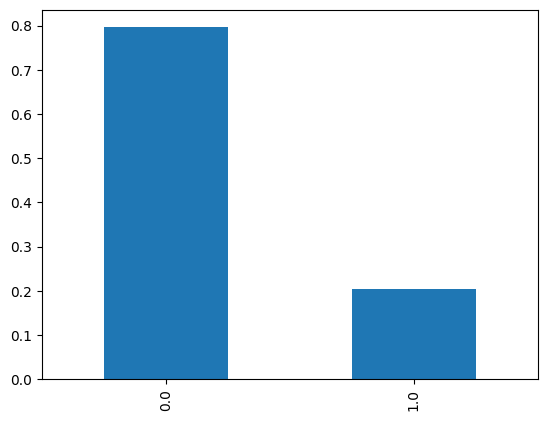

In [9]:
# store the relative frequencies of the target classes in the class_frequency variable then print it
class_frequency = target.value_counts(normalize=True) 
print(class_frequency)

# plot the relative frequencies of the target classes
class_frequency.plot(kind='bar')

There's quite a class imbalance in our target. About 80% of customers have never churned (Exited = 0) while about 20% have churned (Exited = 1).

### Split the Source Data into Training, Validation, and Testing Sets

In [10]:
# split the source data into a training set and validation/testing set
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)

# split the validation/testing df into a separate validation set and testing set
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

The test set doesn't exist yet so the source data (df) has to be split into three parts: training, validation, and test. The sizes of the validation set and test set are usually equal so that gives us source data split in a 3:1:1 ratio.

Consequently, I split the source data into two parts: 60% training data and 40% validation/testing data.
Next, I split the validation/testing data in two equal 50% parts.
Overall, this leaves me with a 3:1:1 ratio as desired with a majority of the data (a sufficient amount) available to train my models with.

### Optimize the Model's Hyperparameters

In [11]:
# inititialize the best_score, best_depth, and best_est variables
best_score = 0
best_est = 0
best_depth = 0

# loop through the n_estimators hyperparameter find the best score
for est in range(1, 30):
    for depth in range (1, 11): # choose hyperparameter range
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # set number of trees
        model.fit(features_train, target_train) # train model on training set
    score = model.score(features_valid, target_valid) # calculate accuracy score on validation set
    if score > best_score:
        best_score = score # save best accuracy score on validation set
        best_est = est # save number of estimators corresponding to best accuracy score
        best_depth = depth # save max depth corresponding to best accuracy score

print("Accuracy of the best model on the validation set (n_estimators = {}, max_depth = {}): {}".format(best_est, best_depth, best_score))

Accuracy of the best model on the validation set (n_estimators = 24, max_depth = 10): 0.8625


Above, the best model (including its optimal values for the n_estimators and max_depth hyperparameters) was determined by looping through various combinations of its hyperparmeters and outputting these values for use in optimizing the model further below.

In [12]:
# initialize the  Random Forest Regressor model without taking the class imbalance into account
model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth)

# train the model using the training set
model.fit(features_train, target_train)

# make predictions on the validation set
predictions_valid = model.predict(features_valid)

# calculate the f1 score and print it
print('F1:', f1_score(target_valid, predictions_valid))


F1: 0.5736434108527132


The random forest classifier model doesn't produce a strong enough f1 score when we don't take the class imbalance into account. Let's take it into account and try again.

In [13]:
model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth, class_weight='balanced') # initialize the model rameter set to 'balanced'
model.fit(features_train, target_train) # fit the model to the downsampled training set
predicted_valid = model.predict(features_valid) # make predictions on the validation set

print(f1_score(target_valid, predicted_valid)) # calculate the f1 score and print 

0.6062052505966585


Using the class_weight='balanced' hyperparameter, we instructed the RandomForestClassifier model to give equal weight to each target.

Now our score is about 0.60, which beats our f1 score requirement, but it could still use some improvement.

Let's see what the f1 score is after applying downsampling instead.

In [14]:
# define the (class) downsample function  
def downsample(features, target, fraction):
    features_zeros = features[target == 0] # store the features of the target class 0
    features_ones = features[target == 1] # store the features of the target class 1
    target_zeros = target[target == 0] # store the target class 0
    target_ones = target[target == 1] # store the target class 1

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]  # downsample the features with a class of 0 and concatenate the features data
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] # downsample the target with a class of 0 and concatenate the target data
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345 # shuffle the features and target
    )
    
    return features_downsampled, target_downsampled # return the downsampled features and target


features_downsampled, target_downsampled = downsample( # downsample the training set's 1 class by a fraction
    features_train, target_train, 0.40
)

model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth) # initialize the model rameter set to 'balanced'
model.fit(features_downsampled, target_downsampled) # fit the model to the downsampled training set
predicted_valid = model.predict(features_valid) # make predictions on the validation set

print(f1_score(target_valid, predicted_valid)) # calculate the f1 score and print it

0.6128654970760233


The f1 score still beats our model's required score of 0.59. 

We downsampled the training set's negative class (giving the model 40% of the negative class data it had to work with before) to help overcome the class imbalance (only ~20% of the target field had a positive class in the original dataset). This modification helped improve the model's f1 a little more than balancing the class weights.

Let's see how this model translates to our testing set!

### Evaluate the Model on the Testing Set

In [15]:
predicted_test = model.predict(features_test) # make predictions on the test set

print(f1_score(target_test, predicted_test)) # calculate the f1 score and print it

0.6013986013986014


Great news! The f1 score for the testing set is still above 0.59. Our model has officially surpassed the project's f1 score requirements.

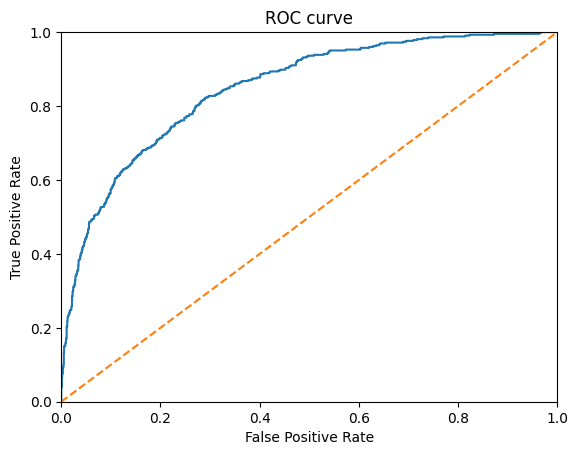

In [16]:
# predict the probabilities of the target classes
probabilities_test = model.predict_proba(features_test)

# calculate the probability of the positive class
probabilities_one_test = probabilities_test[:, 1]

# store the false positive rate, true positive rate, and thresholds of the ROC curve
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

# plot the ROC curve
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [17]:
# calculate the AUC-ROC score and store it in a variable
auc_roc = roc_auc_score(target_test, probabilities_one_test)

# print the AUC-ROC score
print(auc_roc)

0.8472493932429981


The model produced an ROC AUC score of about 0.84, which is a good score.

This score reflects how well a model can distinguish between positive or negative classes across all classification thresholds and ranges from 0 to 1 (a score of 0.5 would represent random guessing while a score of 1 would represent perfect performance.)

# Project Conclusion

Ultimately, the Random Forest Classifier model delivered the performance our project demanded. This model typically performs at a high degree of accuracy because it uses an ensemble of trees instead of just one, which also helps to avoid overfitting. However, as a drawback, it often runs slower compared to a Logistic Regression or Decision Tree model. 

Accuracy is important here because the bank must be able to predict customer churn, and therefore hopefully take the adequate action to prevent it, as accurately as possible. 

With an imbalanced dataset, such as this one, accuracy can be misleading because a model that accurately predicts the majority class can have a high accuracy score but still a low F1 score because is cannot predict the minority class well. 

The f1 score is a more balanced and informative score since it considers both precision (true positives out of predicted positives) and recall (true positive rate), which better measures the model's performance on the minority (positive) class--this is of particular importance in this project. The f1 score is based on a specific threshold whereas the AUC-ROC score considers the performance of the model across all possible thresholds and therefore provies a more robust evaluation of the model.
